<h1>Содержание<span class="tocSkip"></span></h1>

# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузим и подготовим данные. Поясним порядок действий.

### Импорт библитек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats as st

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
BUDGET = 10*10**9
PLACES_TO_EXPLORE = 500
POINTS_OF_WELL = 200
BARREL_PRICE = 450
BARREL_PRICE_1000b = 450*10**3
WELL_PRICE = int(BUDGET / POINTS_OF_WELL)
LOSSES_PROBA_LIMIT = 2.5

In [4]:
data0 = pd.read_csv("/workspaces/Data-Science/Dataset/geo_data_0.csv")
data1 = pd.read_csv("/workspaces/Data-Science/Dataset/geo_data_1.csv")
data2 = pd.read_csv("/workspaces/Data-Science/Dataset/geo_data_2.csv")

In [5]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Примем, что пропуски и аномалии отсутствуют, хоть нам и неизвестны признаки f0, f1, f2

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
data1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Примем, что пропуски и аномалии отсутствуют, хоть нам и неизвестны признаки f0, f1, f2

In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
data2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Примем, что пропуски и аномалии отсутствуют, хоть нам и неизвестны признаки f0, f1, f2

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

### Проверим дубликаты

In [13]:
data0.duplicated().sum()

0

In [14]:
data0.nunique().to_frame(name='Количество')

,Количество
id,99990
f0,100000
f1,100000
f2,100000
product,100000


10 наимнований cкважин повторяються в данных, все остальные данные различаються

In [15]:
data1.duplicated().sum()

0

In [16]:
data1.nunique().to_frame(name='Количество')

,Количество
id,99996
f0,100000
f1,100000
f2,100000
product,12


4 наименования скважин повторяються в данных. Уникальные значения продукта всего 12 показаний

In [17]:
data2.duplicated().sum()

0

In [18]:
data2.nunique().to_frame(name='Количество')

,Количество
id,99996
f0,100000
f1,100000
f2,100000
product,100000


Все значения уникальные

Полные дубликаты отсутствуют

Столбец с 'id' не несет нужной нам информации, его можно удалить

In [19]:
data0 = data0.drop('id', axis=1)
data1 = data1.drop('id', axis=1)
data2 = data2.drop('id', axis=1)

### Изучение и анализ данных

#### Рассмотрим корреляцию данных. Зависимость параметров

In [20]:
data0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


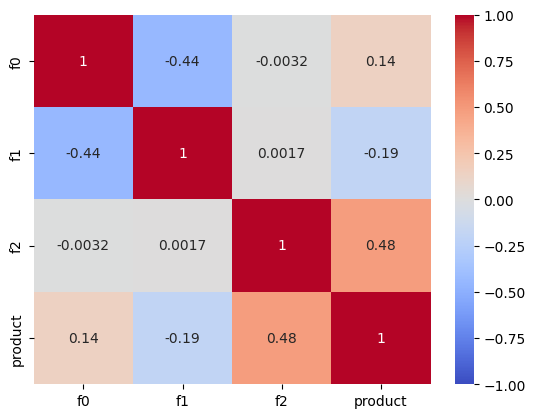

In [21]:
sns.heatmap(data0.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

In [22]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


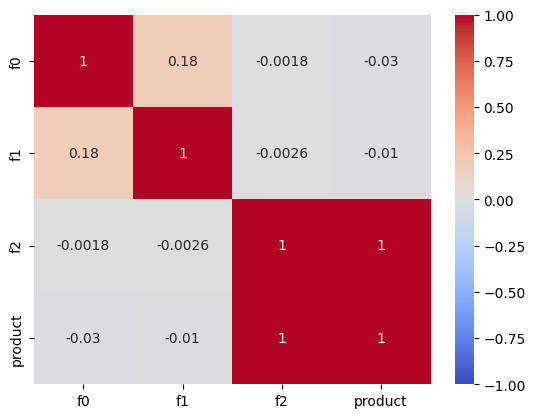

In [23]:
sns.heatmap(data1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

In [24]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


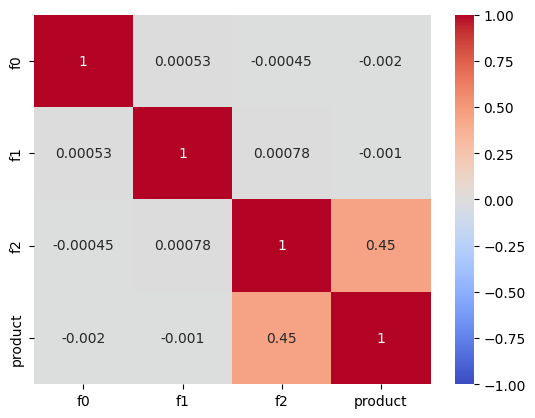

In [25]:
sns.heatmap(data2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Есть корреляция между признаками f2 и product - самая значительная у второго сета, где были обнаружены 12 идентичных значений по продукции. Также для первого региона наблюдается корреляция между признаками f1 и f0

#### Построим общую гистограмму

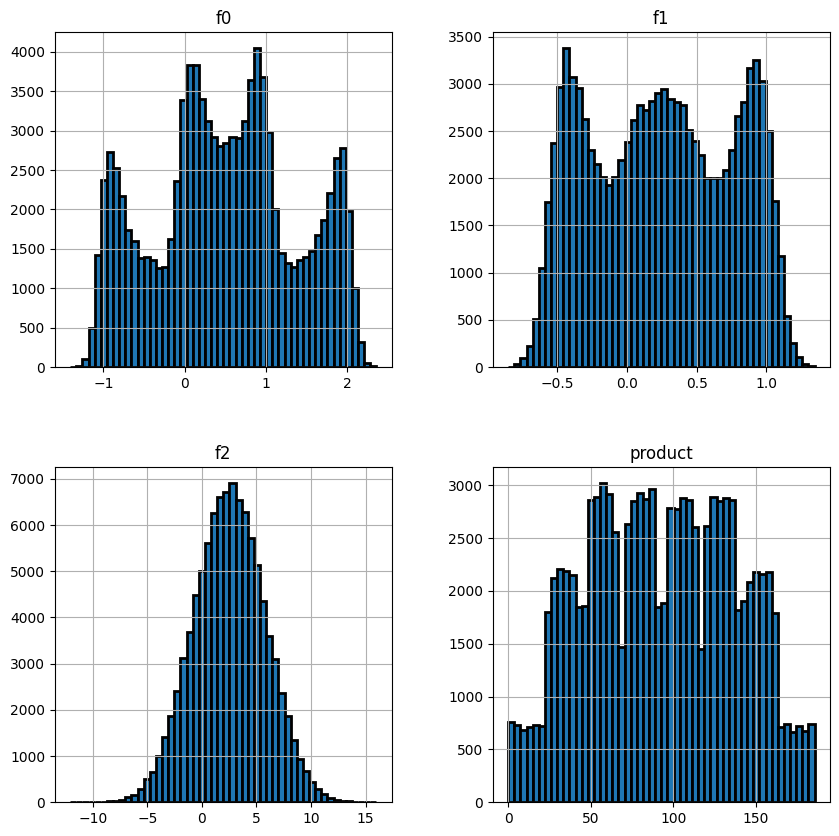

In [26]:
data0.hist(bins=50, figsize=(10, 10), edgecolor='black', linewidth=2);#построили общую гистограмму для первого региона

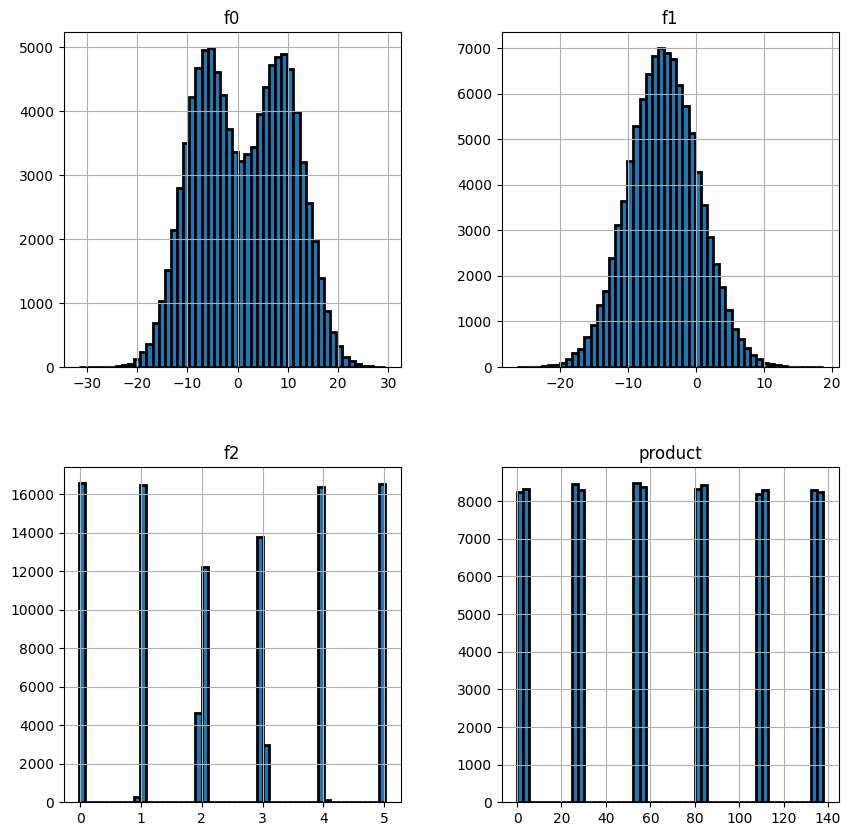

In [27]:
data1.hist(bins=50, figsize=(10, 10), edgecolor='black', linewidth=2);#построили общую гистограмму для второго региона

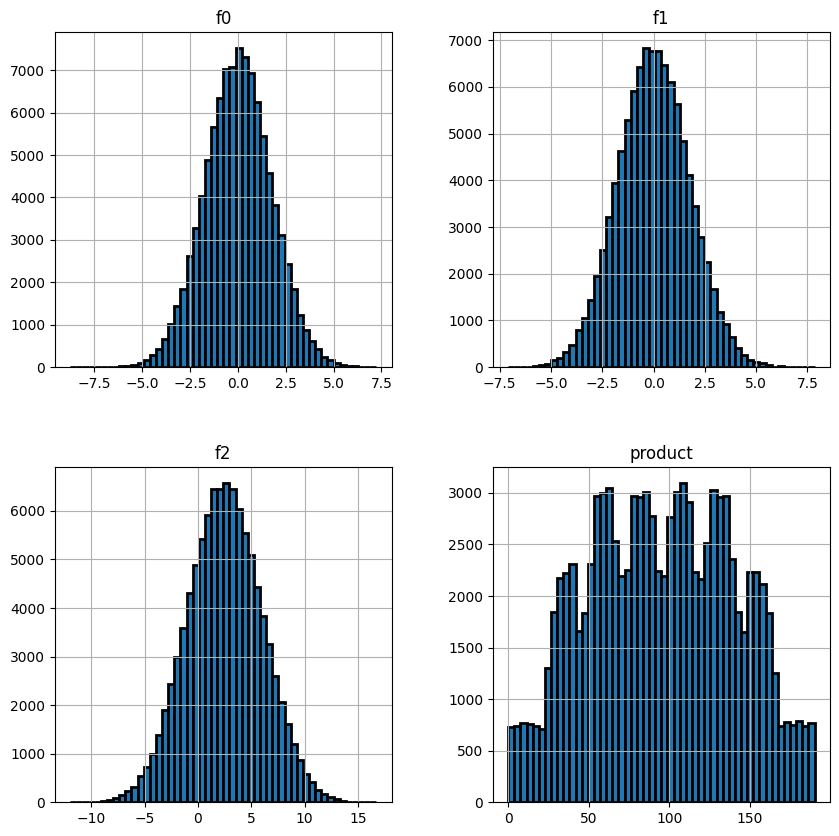

In [28]:
data2.hist(bins=50, figsize=(10, 10), edgecolor='black', linewidth=2);#построили общую гистограмму для третьего региона

### Вывод 

1. Загрузили данные с тремя регионами исследования
2. Дубликаты и пропущенные значения отсутствуют.
3. Но в данных наблюдаются повторения по id, вероятнее всего данный факт связан с тем, что замеры брались несколько раз из одной скважины.
4. Удалии параметр 'id', т.к. для построения модели он не представляет ценности.
3. Про анамалии нельзя сказать определенно, т.к мы не знает что за параметры f0,f1,f2
4. Присутствует зависимость параметра f2 на объём запасов в скважине (тыс. баррелей) 'product'
5. Для второго региона количество уникальных значений 'product' мало. Кроме того параметр f2 распределен не равномерно. Здесь также наблюдается самая большая зависимосст между этими двумя параметрами.

## Обучим и проверим модель для каждого региона:

### Разбьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [29]:
target0 = data0['product']
features0 = data0.drop(['product'] , axis=1)

target1 = data1['product']
features1 = data1.drop(['product'] , axis=1)

target2 = data2['product']
features2 = data2.drop(['product'] , axis=1)

In [30]:
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(features0, target0, test_size=0.25, random_state=12345)
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(features1, target1, test_size=0.25, random_state=12345)
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(features2, target2, test_size=0.25, random_state=12345)

In [31]:
print('Размер обучающей выборки 1 региона', len(target_train0))
print('Размер валидационной выборки 1 региона', len(features_valid0))
print('Размер обучающей выборки 2 региона', len(features_train1))
print('Размер валидационной выборки 2 региона', len(features_valid1))
print('Размер обучающей выборки 3 региона', len(features_train2))
print('Размер валидационной выборки 3 региона', len(features_valid2))

Размер обучающей выборки 1 региона 75000
Размер валидационной выборки 1 региона 25000
Размер обучающей выборки 2 региона 75000
Размер валидационной выборки 2 региона 25000
Размер обучающей выборки 3 региона 75000
Размер валидационной выборки 3 региона 25000


### Обучим модель и сделаем предсказания на валидационной выборке.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). 

#### Для первого региона

In [32]:
fit_intercept = [True, False]
copy_X = [True, False]
positive = [True, False]
#В ходе работы мы генерируем сущность param_dist, содержащую, для каждого гиперпараметра, диапазон значений, которые нужно испытать
param_dist = {'fit_intercept': fit_intercept, 'copy_X': copy_X, 'positive': positive}
model = GridSearchCV(LinearRegression(), 
                     param_dist, 
                     cv = 5, 
                     n_jobs=-1,
                    scoring='neg_root_mean_squared_error')

In [33]:
model0 = model
model0.fit(features_train0, target_train0)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [34]:
rs_df = pd.DataFrame(model0.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 
                    'split4_test_score'], axis=1)
rs_df

,std_score_time,param_copy_X,param_fit_intercept,param_positive,mean_test_score,std_test_score,rank_test_score
0,0.000188,True,True,False,-37.732382,0.074503,1
1,0.000274,False,True,False,-37.732382,0.074503,1
2,0.000161,True,True,True,-38.266999,0.113690,3
3,0.000153,False,True,True,-38.266999,0.113690,3
4,0.000121,True,False,True,-61.160555,0.289304,5
5,0.000157,True,False,False,-61.160555,0.289304,5
6,0.000295,False,False,True,-61.160555,0.289304,5
7,0.000277,False,False,False,-61.160555,0.289304,5


In [35]:
print(model0.best_params_)
print('Лучший mean_test_score модели:', model0.best_score_)# лучший результат модели для параметра rmse

{'copy_X': True, 'fit_intercept': True, 'positive': False}
Лучший mean_test_score модели: -37.73238188617926


In [36]:
predicted_valid0 = model0.predict(features_valid0)
predicted_valid0

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

#### Для второго региона

In [37]:
model1 = model
model1.fit(features_train1, target_train1)
print(model1.best_params_)
print('Лучший mean_test_score модели:', model1.best_score_)# лучший результат модели

{'copy_X': True, 'fit_intercept': True, 'positive': False}
Лучший mean_test_score модели: -0.8895409511809371


In [38]:
predicted_valid1 = model.predict(features_valid1)
predicted_valid1

array([ 82.66331365,  54.43178616,  29.74875995, ..., 137.87934053,
        83.76196568,  53.95846638])

#### Для третьего региона

In [39]:
model2 = model
model2.fit(features_train2, target_train2)
print(model2.best_params_)
print('Лучший mean_test_score модели:', model2.best_score_)# лучший результат модели

{'copy_X': True, 'fit_intercept': True, 'positive': True}
Лучший mean_test_score модели: -40.06530880031179


In [40]:
predicted_valid2 = model.predict(features_valid2)
predicted_valid2

array([ 93.43814051,  75.15878499,  90.04974295, ...,  99.40115389,
        77.77252555, 128.98914204])

### Сохраним предсказания и правильные ответы на валидационной выборке.

In [41]:
def report(rep, y, region, pred):
    rep = pd.DataFrame(y)
    rep['predicted'] = pred
    rep['region'] = region
    return rep

In [42]:
tabl_valid0 = []
tabl_valid0 = report(tabl_valid0, target_valid0, 0, predicted_valid0)
tabl_valid0.head()

,product,predicted,region
71751,10.038645,95.894952,0
80493,114.551489,77.572583,0
2655,132.603635,77.892640,0
53233,169.072125,90.175134,0
91141,122.325180,70.510088,0


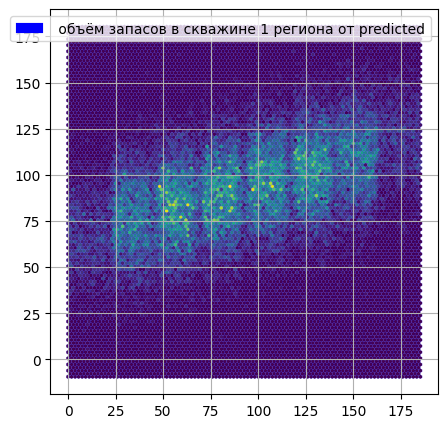

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hexbin(x = tabl_valid0['product'], y = tabl_valid0['predicted'], 
           color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 1, label=" объём запасов в скважине 1 региона от predicted")

plt.legend()
plt.grid(True)

In [44]:
tabl_valid1 =[]
tabl_valid1 = report(tabl_valid1, target_valid1, 1, predicted_valid1)
tabl_valid1.head()

,product,predicted,region
71751,80.859783,82.663314,1
80493,53.906522,54.431786,1
2655,30.132364,29.748760,1
53233,53.906522,53.552133,1
91141,0.000000,1.243856,1


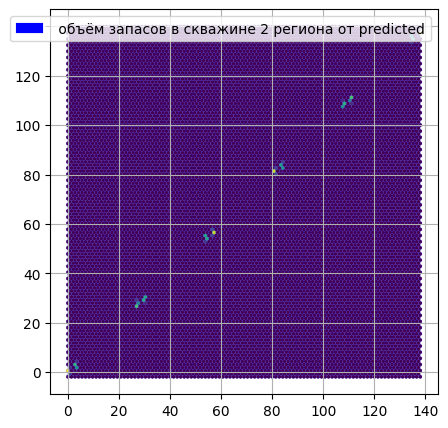

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hexbin(x = tabl_valid1['product'], y = tabl_valid1['predicted'], 
           color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 1, label=" объём запасов в скважине 2 региона от predicted")

plt.legend()
plt.grid(True)

In [46]:
tabl_valid2 = []
tabl_valid2 = report(tabl_valid2, target_valid2, 2, predicted_valid2)
tabl_valid2.head()

,product,predicted,region
71751,61.212375,93.438141,2
80493,41.850118,75.158785,2
2655,57.776581,90.049743,2
53233,100.053761,105.230404,2
91141,109.897122,115.476474,2


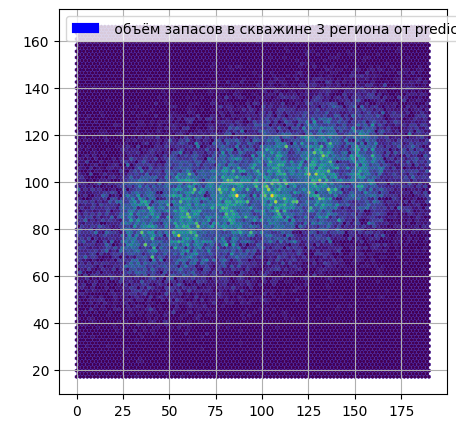

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hexbin(x = tabl_valid2['product'], y = tabl_valid2['predicted'], 
           color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 1, label=" объём запасов в скважине 3 региона от predicted2")

plt.legend()
plt.grid(True)

### Напечатаем  на экране средний запас предсказанного сырья и RMSE модели.

In [48]:
print('Средние запасы по 1 региону: {:.2f}'.format(tabl_valid0['product'].mean()),'\n',
'MSE модели: {:.2f}'.format(mean_squared_error(target_valid0, predicted_valid0)),'\n',
'RMSE модели: {:.2f}'.format(np.sqrt(mean_squared_error(target_valid0, predicted_valid0))),'\n',
'MAE модели: {:.2f}'.format(mean_absolute_error(target_valid0, predicted_valid0)),'\n',
'Коэффициент детерминации R2:{:.2f}'.format(r2_score(target_valid0, predicted_valid0)))

Средние запасы по 1 региону: 92.08 
 MSE модели: 1412.21 
 RMSE модели: 37.58 
 MAE модели: 30.92 
 Коэффициент детерминации R2:0.28


In [49]:
print('Средние запасы по 2 региону: {:.2f}'.format(tabl_valid1['product'].mean()),'\n',
'MSE модели: {:.2f}'.format(mean_squared_error(target_valid1, predicted_valid1)),'\n',
'RMSE модели: {:.2f}'.format(np.sqrt(mean_squared_error(target_valid1, predicted_valid1))),'\n',
'MAE модели: {:.2f}'.format(mean_absolute_error(target_valid1, predicted_valid1)),'\n',
'Коэффициент детерминации R2:{:.2f}'.format(r2_score(target_valid1, predicted_valid1)))

Средние запасы по 2 региону: 68.72 
 MSE модели: 0.80 
 RMSE модели: 0.89 
 MAE модели: 0.72 
 Коэффициент детерминации R2:1.00


In [50]:
print('Средние запасы по 3 региону: {:.2f}'.format(tabl_valid2['product'].mean()),'\n',
'MSE модели: {:.2f}'.format(mean_squared_error(target_valid2, predicted_valid2)),'\n',
'RMSE модели: {:.2f}'.format(np.sqrt(mean_squared_error(target_valid2, predicted_valid2))),'\n',
'MAE модели: {:.2f}'.format(mean_absolute_error(target_valid2, predicted_valid2)),'\n',
'Коэффициент детерминации R2:{:.2f}'.format(r2_score(target_valid2, predicted_valid2)))

Средние запасы по 3 региону: 94.88 
 MSE модели: 1602.38 
 RMSE модели: 40.03 
 MAE модели: 32.79 
 Коэффициент детерминации R2:0.21


### Проверим модели на адекватность

In [51]:
target_pred_constant0 = pd.Series(target_train0.median(), index=target_valid0.index)
print('MAE константы 1 региона: {:.2f}'.format(mean_absolute_error(target_valid0, target_pred_constant0)))

MAE константы 1 региона: 37.67


In [52]:
target_pred_constant1 = pd.Series(target_train1.median(), index=target_valid1.index)
print('MAE константы 2 региона: {:.2f}'.format(mean_absolute_error(target_valid1, target_pred_constant1)))

MAE константы 2 региона: 40.27


In [53]:
target_pred_constant2 = pd.Series(target_train2.median(), index=target_valid2.index)
print('MAE константы 3 региона: {:.2f}'.format(mean_absolute_error(target_valid2, target_pred_constant2)))

MAE константы 3 региона: 37.92


### Проанализируем результаты.

Первый регион:  
Средние запасы по 1 региону, предсказанные моделью: 92.08   
 MSE модели: 1412.21   
 RMSE модели: 37.58   
 MAE модели: 30.92 Меньше чем для константы  37.67
 Коэффициент детерминации R2:0.28 Довольно низкий  

Второй регион:  
Средние запасы по 2 региону, предсказанные моделью: 68.72   
 MSE модели: 0.80   
 RMSE модели: 0.89   
 MAE модели: 0.72   Намного меньше костнанты 40.27
 Коэффициент детерминации R2:1.00  

Третий регион:  
Средние запасы по 3 региону, предсказанные моделью: 94.88   
 MSE модели: 1602.38   
 RMSE модели: 40.03   
 MAE модели: 32.79 Меньше константы 37.92
 Коэффициент детерминации R2:0.21  
 
Вывод: Идеально показала себя модель линейной регресии для второго региона. Но значение метрики R2 равно единице только в одном случае, если MSE нулевое. Такая модель предсказывает все ответы идеально. Такое никогда не бывает - это означает что все прогнозы на тренировочных данных совпали с валидационными. Т.е. прогнозы имееют нулеву ошибку. Нулевая ошибка может быть только при отсутствии вероятного характера. Скорее всего повлияла сильная корреляция признаков f2 к запасу для данного региона. Следовательно, нужно уточнить корректность данных по региону. Использовать данные будет не корректно.  
Между первым и третьим регионом нет большой разницы в метриках моделей. Чуть лучше себя показала модель по первому региону. Но и запасов там чуть меньше.

## Подготовимся к расчёту прибыли:

### Все ключевые значения для расчётов сохраним в отдельных переменных.

In [54]:
tabl_const = pd.DataFrame({'Бюджет, руб': [BUDGET], 'Количество скважин, ед.':[PLACES_TO_EXPLORE], 'Количество скважин для разработки, ед.':[POINTS_OF_WELL],
                        'Стоимость бурения 1 скважины, руб': [WELL_PRICE], 'Цена за баррелей, руб':[BARREL_PRICE], 'Цена за 1000 баррелей, руб':[BARREL_PRICE_1000b]
                         }).T

tabl_const

,0
"Бюджет, руб",10000000000
"Количество скважин, ед.",500
"Количество скважин для разработки, ед.",200
"Стоимость бурения 1 скважины, руб",50000000
"Цена за баррелей, руб",450
"Цена за 1000 баррелей, руб",450000


### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 


In [55]:
oil_well = WELL_PRICE / BARREL_PRICE_1000b

print('Достаточный объём сырья для безубыточной разработки новой скважины, тыс. бар.: {:.2f}'.format(oil_well))

Достаточный объём сырья для безубыточной разработки новой скважины, тыс. бар.: 111.11


In [56]:
# проверка уровня безубыточности
good_reg_0 = (data0.query('product >= 111.11').shape[0]) / (data0.shape[0])
print('Доля безубыточных скважин в первом регионе: {:.2%}'.format(good_reg_0))
good_reg_1 = (data1.query('product >= 111.11').shape[0]) / (data1.shape[0])
print('Доля безубыточных скважин во втором регионе: {:.2%}'.format(good_reg_1))
good_reg_2 = (data2.query('product >= 111.11').shape[0]) / (data2.shape[0])
print('Доля безубыточных скважин в третьем регионе: {:.2%}'.format(good_reg_2))

Доля безубыточных скважин в первом регионе: 36.58%
Доля безубыточных скважин во втором регионе: 16.54%
Доля безубыточных скважин в третьем регионе: 38.18%


### Напишем выводы по этапу подготовки расчёта прибыли.

В каждом регионе есть доля безубыточных скважин. они нас больше всего интересуют. Меньше всего безубыточных скважин во втром регионе, средний объем сырья для безубыточной разработки новых скважин равен 111,11 тыс. бар.

Есть 25 000 точек, из которых в результате надо выбрать 200. В результате,  среди этих скважин могут быть скважины с достаточным и недостаточным запасом сырья, поэтому точность прогноза имеет большое значение и без модели нам не обойтись.   
    
Имеено техника "Bootstrap" опираясь на предсказания позволяет оценить риск убытков при случайным отборе 500 точек. 1000 раз отбирая случайным образом точки, считаем какой % случаев принесет убытки. 

## Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

Опишем действие функции подробно: 
1. В функцию в виде аргумента поступает список предсказанных объёмов запасов в скважинах.
2. Выберем скважины с максимальными значениями предсказаний. 
3. росуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
4. Рассчитаем прибыль для полученного объёма сырья.

In [57]:
values = []
def profit(report):
    top_200 = report.sort_values(by=['predicted'], ascending=False)[:200]
    sort_sum = report['product'][top_200.index].sum() 
    profit = ((sort_sum*(10**3) * BARREL_PRICE) - BUDGET)/(10**9)
    print('Прогнозируемый моделью доход с региона, млрд. рублей :{:.2f}'.format(profit))
    return 

In [58]:
profit(tabl_valid0)
profit(tabl_valid1)
profit(tabl_valid2)


Прогнозируемый моделью доход с региона, млрд. рублей :3.32
Прогнозируемый моделью доход с региона, млрд. рублей :2.42
Прогнозируемый моделью доход с региона, млрд. рублей :2.69


### Вывод

Самая высокая прибыль прогнозируется для первого региона. Посчитаем риски и прибыль для каждого региона

## Посчитаем риски и прибыль для каждого региона:

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [59]:
# Для формирования итоговой таблицы
tabl_reg = []
tabl_mean = []
tabl_lower = []
tabl_upper = []
tabl_confidence_interval = []
tabl_risk = []
tabl_loss_rate = []
statistics = []

In [60]:
def distribution_of_profits(region):
    values = []
    state = np.random.RandomState(42) 
    
    for i in range(1000):
        
        probs_subsample = region['predicted'].sample(n=500, replace=True, random_state=state)     
        probs_top = probs_subsample.sort_values(ascending=False)
        cur_top_200 = region['product'][probs_top.index][:200]        
        profit = ((BARREL_PRICE_1000b * cur_top_200.sum()) - BUDGET)/ (10**9)
        values.append(profit)
        
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    confidence_interval = st.t.interval(0.95, len(values)-1, 
                                        mean, values.sem())
    
    risks_sum = 0
    
    for value in values:
        if value < 0:
            risks_sum += 1
        
    risk = risks_sum / len(values)*100
    # проверка уровня вероятности убытков
            
    print('Средняя выручкаб млрд. руб.: {:.2f}'.format(mean)),
    print('2.5%-квантиль: {:.2f}'.format(lower)),
    print('97.5%-квантиль: {:.2f}'.format(upper)),
    print('95% доверительный интервал: ', confidence_interval),
    print('Риски, %: {:.2f}'.format(risk))
    if risk > LOSSES_PROBA_LIMIT:
        print(f'Вероятность убытков по Региону в {risk:.1f}% превышает критический уровень {LOSSES_PROBA_LIMIT}%.')
    else:
        print(f'Вероятность убытков по Региону в {risk:.1f}% меньше критического уровня {LOSSES_PROBA_LIMIT}%.')
    
    tabl_mean.append(round(mean, 2))
    tabl_lower.append(round(lower, 2))
    tabl_upper.append(round(upper, 2))
    tabl_confidence_interval.append(confidence_interval)
    tabl_risk.append(round(risk,2))
    tabl_loss_rate.append(round(2.5, 2))
    
    statistic = pd.DataFrame({ 'Средняя выручка в млрд. руб.':tabl_mean, 
                               '2.5%-квантиль':tabl_lower, '97.5%-квантиль': tabl_upper,
                             '95% доверительный интервал':tabl_confidence_interval, 'Риски, %':tabl_risk, 
                             'критический уровень риска, %':tabl_loss_rate})
    return statistic

In [61]:
distribution_of_profits(tabl_valid0)

/tmp/ipykernel_14125/2082534330.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cur_top_200 = region['product'][probs_top.index][:200]


Средняя выручкаб млрд. руб.: 0.38
2.5%-квантиль: -0.10
97.5%-квантиль: 0.88
95% доверительный интервал:  (0.36582508606891984, 0.39743199826025)
Риски, %: 7.30
Вероятность убытков по Региону в 7.3% превышает критический уровень 2.5%.


,Средняя выручка в млрд. руб.,2.5%-квантиль,97.5%-квантиль,95% доверительный интервал,"Риски, %","критический уровень риска, %"
0,0.38,-0.1,0.88,"(0.36582508606891984, 0.39743199826025)",7.3,2.5


In [62]:
distribution_of_profits(tabl_valid1)

/tmp/ipykernel_14125/2082534330.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cur_top_200 = region['product'][probs_top.index][:200]


Средняя выручкаб млрд. руб.: 0.45
2.5%-квантиль: 0.07
97.5%-квантиль: 0.85
95% доверительный интервал:  (0.4391017958827118, 0.4644726365340833)
Риски, %: 0.70
Вероятность убытков по Региону в 0.7% меньше критического уровня 2.5%.


,Средняя выручка в млрд. руб.,2.5%-квантиль,97.5%-квантиль,95% доверительный интервал,"Риски, %","критический уровень риска, %"
0,0.38,-0.10,0.88,"(0.36582508606891984, 0.39743199826025)",7.3,2.5
1,0.45,0.07,0.85,"(0.4391017958827118, 0.4644726365340833)",0.7,2.5


In [63]:
distribution_of_profits(tabl_valid2)

/tmp/ipykernel_14125/2082534330.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cur_top_200 = region['product'][probs_top.index][:200]


Средняя выручкаб млрд. руб.: 0.39
2.5%-квантиль: -0.12
97.5%-квантиль: 0.92
95% доверительный интервал:  (0.3736811790145929, 0.4074032801760356)
Риски, %: 8.00
Вероятность убытков по Региону в 8.0% превышает критический уровень 2.5%.


,Средняя выручка в млрд. руб.,2.5%-квантиль,97.5%-квантиль,95% доверительный интервал,"Риски, %","критический уровень риска, %"
0,0.38,-0.10,0.88,"(0.36582508606891984, 0.39743199826025)",7.3,2.5
1,0.45,0.07,0.85,"(0.4391017958827118, 0.4644726365340833)",0.7,2.5
2,0.39,-0.12,0.92,"(0.3736811790145929, 0.4074032801760356)",8.0,2.5


##  Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

1. В данных наблюдаются повторения по id, вероятнее всего данный факт связан с тем, что замеры брались несколько раз из одной скважины.
2. Присутствует зависимость параметра f2 на объём запасов в скважине (тыс. баррелей) 'product' для второго региона
3. Для второго региона количество уникальных значений 'product' мало. Кроме того параметр f2 распределен не равномерно.
4. Идеально показала себя модель линейной регресии для второго региона. Но значение метрики R2 равно единице только в одном случае, если MSE нулевое. Такая модель предсказывает все ответы идеально. Такое никогда не бывает - это означает что все прогнозы на тренировочных данных совпали с валидационными. Т.е. прогнозы имееют нулеву ошибку. Нулевая ошибка может быть только при отсутствии вероятного характера. Скорее всего повлияла сильная корреляция признаков f2 к запасу для данного региона. Следовательно, нужно уточнить корректность данных по региону. Использовать данные будет не корректно.
5. В каждом регионе есть доля безубыточных скважин, они нас больше всего интересуют. Меньше всего безубыточных скважин во втром регионе, средний объем сырья для безубыточной разработки новых скважин равен 111,11 тыс. бар.
6. Самым привлекательным для разработки месторождений являеться Первый регион, с прогнозируемой прибылью 3.32 млрд. рублей
7. уровень риска меньше критического(2,5%) получить прибыль смог преодолеть только Второй регион. Где присутствует 95% шанс получить прибыль больше 0.43 млрд. руб. Риск стать убыточным составляет только 0.7 %
8. При правильности данных второго регина, выбираем его, как единиственно удовлетваряющего условиям задачи. Притом можно обратить внимание. что на количество запасов большое влияние оказывает фактор f2.